In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
from tensorflow.keras.utils import to_categorical,plot_model

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


In [4]:
BASE_DIR = path

In [5]:
# make inceptionv3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)


In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [9]:
# extract features from the images
feature|s = {}
directory = os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory,img_name)
    # load images and set target size
    image = load_img(img_path,target_size = (299,299))
    # convert image to array
    image = img_to_array(image)
    # reshape the image
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2])) # (1,299,299,3)
    # preprocess the input
    image = preprocess_input(image)
    # extract features
    feature  = model.predict(image,verbose =0)
    # get image id
    image_id = img_name.split('.')[0]
    store the feature
    features[image_id] = feature


In [13]:
# pickle.dump(features,open('/content/drive/MyDrive/features.pkl','wb'))

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
with open('/content/drive/MyDrive/features.pkl','rb') as f:
  features = pickle.load(f)

In [11]:
len(features)

8091

In [14]:
features['1093737381_b313cd49ff']

array([[0.42273778, 0.39303756, 1.8379287 , ..., 0.02290058, 0.88128453,
        0.07793289]], dtype=float32)

# Load the captions Data

In [12]:
# load captions.txt
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [13]:
# create mapping of images of captions
mapping = {}
# preprocess the tokens
for line in tqdm(captions_doc.split('\n')):
  # splite the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  # splite image_ids, captions
  image_id, caption = tokens[0], tokens[1:]
  # remove extension from image_id
  image_id = image_id.split('.')[0]
  # convert captions_list into string
  caption = " ".join(caption)
  # append caption to corresponding image_id
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

# Preprocess the Captions

In [14]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocessing steps
      # convert to lower case
      caption = caption.lower()
      # remove other punctuations
      caption = caption.replace('[^A-Za-z]','')
      # replace extra spaces with single spaces
      caption = caption.replace('\s+', ' ')
      # insert start and end token for generation
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
      # move back
      captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-810413300.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [15]:
mapping['1093737381_b313cd49ff']

['A woman in a blue dress stands with a chalk portrait of two children playing by a stream .',
 'A woman standing in front of a chalk drawing',
 'A woman stands next to a chalk drawing in front of a barn-like structure .',
 'A woman stands outside near an elaborate chalk illustration .',
 'A woman wearing a blue dress is drawing a picture of a boy and a girl on the sidewalk with sidewalk chalk .']

In [16]:
clean(mapping)

In [17]:
mapping['1093737381_b313cd49ff']

['startseq woman in blue dress stands with chalk portrait of two children playing by stream endseq',
 'startseq woman standing in front of chalk drawing endseq',
 'startseq woman stands next to chalk drawing in front of barn-like structure endseq',
 'startseq woman stands outside near an elaborate chalk illustration endseq',
 'startseq woman wearing blue dress is drawing picture of boy and girl on the sidewalk with sidewalk chalk endseq']

# Tokenization and Padding

In [18]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [19]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [20]:
len(all_captions)

40455

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

8485

In [23]:
# get maximum length of the captions available
max_length = max(len(caption.split()) for caption in all_captions)

# Train Test Split

In [26]:
image_ids = list(mapping.keys())

In [27]:
split = int(len(image_ids) * 0.75)
train = image_ids[:split]
test = image_ids[split:]

In [28]:
len(train)

6068

In [29]:
len(test)

2023

In [30]:
seq = tokenizer.texts_to_sequences(['woman standing in front of a chalk drawing'])[0]
seq

[17, 37, 3, 47, 11, 54, 1395, 1633]

# Data Generator

In [31]:
# create data generator to get data in batch
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
  # loop over images
  X1,X2,y = list(), list(), list()
  # this is useful for reaching the batch size or not i.e n = 0
  n = 0
  while 1:
    for key in data_keys:
      n +=1
      captions = mapping[key]
      # preprocess each captions
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence in X,y pairs
        for i in range(1,len(seq)):
          # splite into input and output paris
          in_seq,out_seq = seq[:i],seq[i]
          # pad input sequences
          in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
          # encode output sequences
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
          # appending in X1, X2, y
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield ((X1, X2), y)
        X1, X2, y = list(), list(), list()
        n = 0

# Model Building

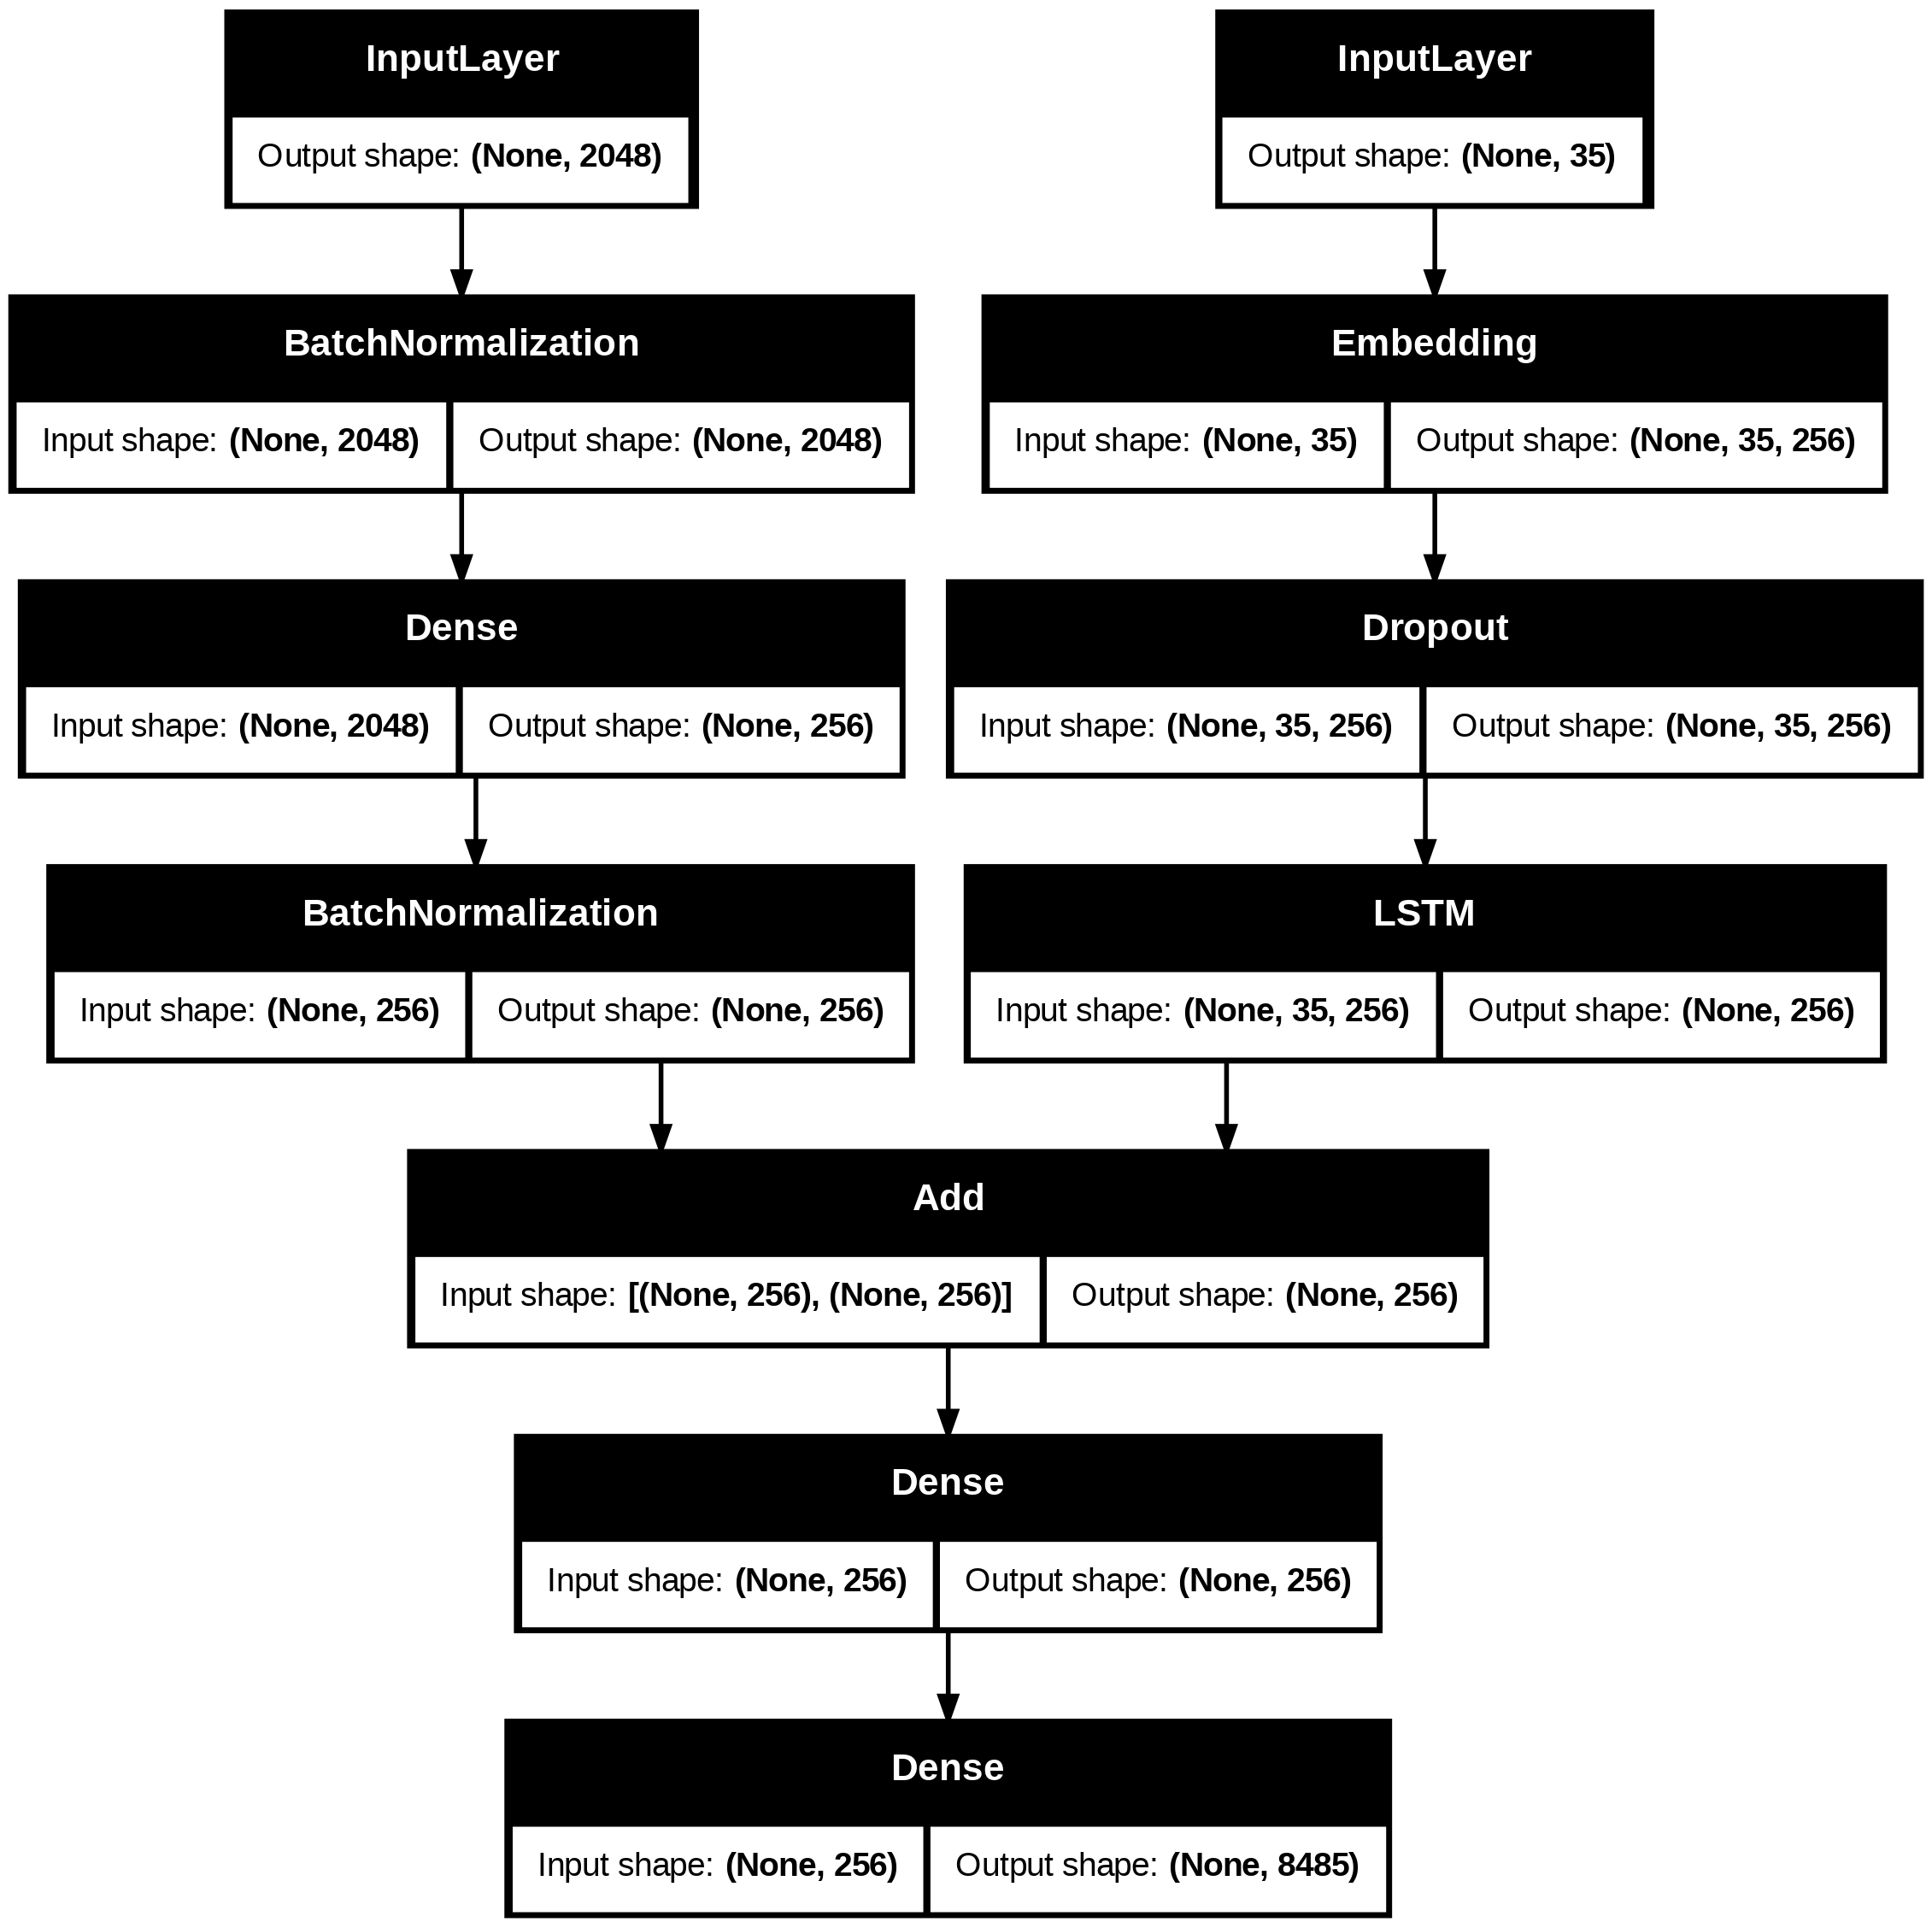

In [34]:
from tensorflow.keras.layers import BatchNormalization
# Image Feature Model
inputs1 = Input(shape = (2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(256,activation = 'relu')(fe1)
fe3 = BatchNormalization()(fe2)
# Sequence feature layers
inputs2 = Input(shape =(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=False)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe3,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1,inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

# plot the model

plot_model(model, show_shapes = True)

In [35]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │  2,172,160 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 35, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,477,669 (20.90 MB)

 Trainable params: 5,473,061 (20.88 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [36]:
len(features)

8091

In [37]:
# train the model
epochs = 20
batch_size = 32
steps = len(train)//batch_size
for i in range(epochs):
  # create data generator
  generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
  # fit for one epoch
  model.fit(generator,steps_per_epoch=steps,verbose = 1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 51s 234ms/step - loss: 6.1258
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - loss: 4.2843
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - loss: 3.6603
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - loss: 3.2790
189/189 ━━━━━━━━━━━━━━━━━━━━ 46s 243ms/step - loss: 2.9812
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - loss: 2.7542
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - loss: 2.6108
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - loss: 2.5025
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - loss: 2.3868
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - loss: 2.2785
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - loss: 2.1858
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - loss: 2.1173
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - loss: 2.0496
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - loss: 1.9878
189/189 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - loss: 1.9314
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - loss: 1.8777
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - loss: 1.82

In [39]:
from tensorflow.keras.models import load_model
model.save('/content/best_model1.h5')

# Generate Captions Using Greedy Search for the image

In [40]:
def idx_to_word(num,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == num:
      return word

  return None

In [77]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for i in range(max_length):
        # convert text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # ensure both are numpy arrays
        image_input = np.array(image).reshape((1, image.shape[1]))  # e.g. (1, 4096)
        sequence_input = np.array(sequence)

        # predict next word
        yhat = model.predict([image_input, sequence_input], verbose=0)

        # get index with max probability
        yhat = np.argmax(yhat)
        # map index to word
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        # append word
        in_text += ' ' + word
        if word == 'endseq':
            break

    return in_text

In [42]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  actual_caption = [caption.split() for caption in captions]
  actual.append(actual_caption)
  predicted.append(y_pred.split())

# calculate BELU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual,predicted,weights = (0.5,0.5,0,0,0)))

  0%|          | 0/2023 [00:00<?, ?it/s]

BLEU-1: 0.509130
BLEU-2: 0.295753


In [78]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_captions(image_name):
  # create image id
  image_id = image_name.split(".")[0]
  img_path = os.path.join(BASE_DIR,'Images',image_name)
  image = Image.open(img_path)
  # actual captions
  captions = mapping[image_id]
  for caption in captions:
    caption = (" ".join(caption.split()[1:]))
    print(" ".join(caption.split()[:-1]))

  # predicted captions
  predicted_captions = predict_caption(model,features[image_id],tokenizer,max_length)
  predicted_captions = (" ".join(predicted_captions.split()[1:]))
  print(" ".join(predicted_captions.split()[:-1]))

  # visualize the image
  plt.imshow(image)


man is standing in front of skyscraper
man stands in front of skyscraper
man stands in front of very tall building
behind the man in red shirt stands large skyscraper
there is skyscraper in the distance with man walking in front of the camera
man stands in the distance


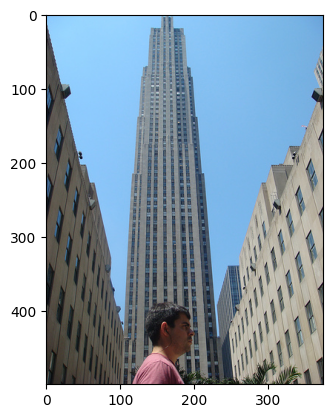

In [80]:
generate_captions('1032460886_4a598ed535.jpg')

male does an open leg trick while doing wheelie on his bike
man is doing wheelie on motorcycle while stretching his legs outwards
"a man with red black and white jacked on is riding on motorcycle ."
man puts legs up in air while riding bike
person riding bike doing while
the motorcycle rider riding motorcycle


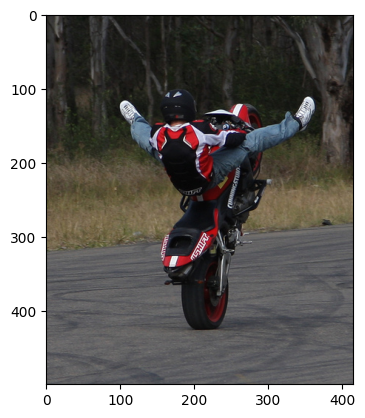

In [54]:
generate_captions(f'{test[23]}.jpg')

# Caption Generation using Beam Search

In [55]:
import numpy as np

def predict_caption_beam(model, image, tokenizer, max_length, beam_width=3):
    """
    Generate caption for an image using Beam Search.
    """

    # Start with the start token
    start_seq = ['startseq']
    # Each element: (sequence_so_far, probability)
    beam = [(start_seq, 0.0)]

    for _ in range(max_length):
        candidates = []
        # Expand each sequence in the beam
        for seq, score in beam:
            # Stop if the sentence already ended
            if seq[-1] == 'endseq':
                candidates.append((seq, score))
                continue

            # Convert sequence to tokens
            sequence = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)

            # Predict next word probabilities
            yhat = model.predict([image, sequence], verbose=0)
            yhat = np.log(yhat[0] + 1e-10)  # use log for numerical stability

            # Get top beam_width words
            top_indexes = np.argsort(yhat)[-beam_width:]

            # Create new candidate sequences
            for idx in top_indexes:
                word = tokenizer.index_word.get(idx)
                if word is None:
                    continue
                new_seq = seq + [word]
                new_score = score + yhat[idx]
                candidates.append((new_seq, new_score))

        # Sort all candidates by score (descending)
        ordered = sorted(candidates, key=lambda tup: tup[1], reverse=True)
        # Select the top beam_width sequences
        beam = ordered[:beam_width]

    # Pick the sequence with the best score
    final_seq = beam[0][0]

    # Join words into sentence, removing start and end tokens
    caption = ' '.join([word for word in final_seq if word not in ['startseq', 'endseq']])
    return caption


In [72]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def generate_captions(image_name, model, features, tokenizer, mapping, max_length, beam_width=5):
    """
    Display an image, show its actual captions, and generate a predicted caption using Beam Search.
    """

    # --- Step 1: Prepare the image and ID ---
    image_id = image_name.split(".")[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)

    if not os.path.exists(img_path):
        print(f"❌ Image not found at path: {img_path}")
        return

    image = Image.open(img_path)

    # --- Step 2: Show the actual captions ---
    print("🟢 Actual Captions:")
    if image_id in mapping:
        for i, caption in enumerate(mapping[image_id], 1):
            # Clean startseq and endseq for readability
            cleaned_caption = caption.replace("startseq", "").replace("endseq", "").strip()
            print(f"{i}. {cleaned_caption}")
    else:
        print("No actual captions found for this image.")

    # --- Step 3: Predict caption using Beam Search ---
    print("\n🚀 Predicted Caption (Beam Search):")
    if image_id in features:
        feature_vector = features[image_id].reshape((1, 2048))
        predicted_caption = predict_caption_beam(model, feature_vector, tokenizer, max_length, beam_width)
        print(predicted_caption)
    else:
        print(f"⚠️ Features not found for image ID: {image_id}")
        return

    # --- Step 4: Visualize the image ---
    plt.imshow(image)
    plt.axis("off")
    plt.show()


🟢 Actual Captions:
1. male does an open leg trick while doing wheelie on his bike
2. man is doing wheelie on motorcycle while stretching his legs outwards
3. "a man with red black and white jacked on is riding on motorcycle ."
4. man puts legs up in air while riding bike
5. person riding bike doing while

🚀 Predicted Caption (Beam Search):
motorcycle rider riding motorcycle


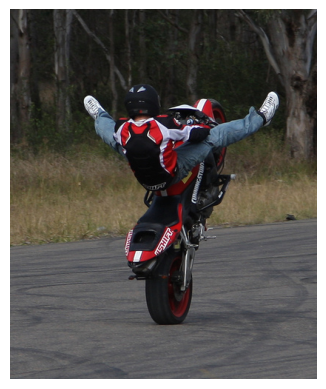

In [75]:
generate_captions(f"{test[23]}.jpg", model, features, tokenizer, mapping, max_length, beam_width=5)